# **Loading libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
sns.set()
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# **Reading masked data**

In [ ]:
##Loading the mmasked data csv file. 
##Csv has 4 coulumns, which are age,ethnicity, gender and pixels repectively
##Pixels column contains the 48*48 pixel values of face image, and rest are the respective labels
#Replace parameter by the path of csv file
df_final = pd.read_csv('/content/drive/MyDrive/ML_extension/new2.csv')

In [ ]:
#Insight to data
df_final.head()

,Unnamed: 0,age,ethnicity,gender,pixels
0,0,82,0,0,98 84 81 81 78 79 75 72 69 64 60 59 57 52 54 5...
1,1,82,0,0,226 224 216 209 203 181 130 72 57 73 68 60 55 ...
2,2,81,0,0,202 202 201 201 201 199 200 200 198 198 197 19...
3,3,80,2,1,223 223 223 223 223 223 223 223 223 219 218 21...
4,4,81,0,0,141 190 183 163 142 138 132 136 121 115 112 11...


In [ ]:
#Removing the labels of ethncity which are out of the desired labels , 0 ,1,2,3,4
df_final=df_final.loc[(df_final.ethnicity==0 ) | ( df_final.ethnicity==1) | ( df_final.ethnicity==2) | ( df_final.ethnicity==3) | (df_final.ethnicity==4)

In [ ]:
#Getting number of images from each ethnicity, 0 represents white, 1 represents black,2 represents asian,3 represents indian and 4 represents others
df_final.ethnicity.value_counts()

0    11342
1     4959
3     4468
2     3860
4     1893
Name: ethnicity, dtype: int64

In [ ]:
#Getting number of males and females in data. 0 represents male and 1 represents female
df_final.gender.value_counts()

0    13852
1    12670
Name: gender, dtype: int64

In [ ]:
#Getting the number of people beonging to each age
df_final.age.value_counts()

26     2434
1      1226
28     1022
35     1008
24      970
       ... 
115       4
116       3
101       2
91        2
111       1
Name: age, Length: 103, dtype: int64

In [ ]:
#Converting pixels to array of pixels
df_final['pixels'] = df_final['pixels'].apply(lambda x: np.array(x.split(), dtype="float32"))

#printing rows and colums
#print(df.shape)
#print(df_final.head())

# normalizing pixels data
df_final['pixels'] = df_final['pixels'].apply(lambda x: x/255)
df_final = df_final.sample(frac=1).reset_index(drop=True)

#COnverting to list
X = np.array(df_final['pixels'].tolist())
#printing shape of X
print(X.shape)

#printing 1st element of X
print(X[0])

#printing len of X[0]
print(len(X[0]))

# print(X.shape[0])

# Converting pixels from 1D to 3D
X = X.reshape(X.shape[0],48,48,1)

#printing shape of new X
print(X.shape[0])
print(X[0])

#X is our final list of input images that will be fed into the model

(26522, 2304)
[0.40784314 0.40392157 0.41568628 ... 0.76862746 0.7607843  0.7607843 ]
2304
26522
26522
[[[0.40784314]
  [0.40392157]
  [0.41568628]
  ...
  [0.7764706 ]
  [0.7764706 ]
  [0.74509805]]

 [[0.39607844]
  [0.40392157]
  [0.42352942]
  ...
  [0.72156864]
  [0.79607844]
  [0.7921569 ]]

 [[0.39215687]
  [0.40784314]
  [0.43137255]
  ...
  [0.73333335]
  [0.7882353 ]
  [0.81960785]]

 ...

 [[0.38431373]
  [0.2901961 ]
  [0.21960784]
  ...
  [0.75686276]
  [0.7647059 ]
  [0.76862746]]

 [[0.27450982]
  [0.19607843]
  [0.2       ]
  ...
  [0.7647059 ]
  [0.76862746]
  [0.76862746]]

 [[0.22352941]
  [0.16078432]
  [0.22352941]
  ...
  [0.76862746]
  [0.7607843 ]
  [0.7607843 ]]]


In [ ]:
#Loading the labels, the Y
y_new = np.array(df_final[['gender', 'ethnicity', 'age']])

# Splitting the data
# Training-60%, Validation-20%, Testing-20%
X_train, X_test, y_train, y_test = train_test_split(X, y_new, test_size=0.2, random_state=42)
X_train, X_cv, y_train, y_cv = train_test_split(X_train,y_train,test_size = 0.25,train_size =0.75)

# Segregating the labels into different arrays

y_gender_train = y_train[:,0]
y_gender_test = y_test[:,0]
y_gender_cv = y_cv[:,0]

y_age_train = y_train[:,2]
y_age_test = y_test[:,2]
y_age_cv = y_cv[:,2]

y_ethnicity_train = y_train[:,1]
y_ethnicity_test = y_test[:,1]
y_ethnicity_cv = y_cv[:,1]

#Finding the position to slice
eth_train_len = len(y_ethnicity_train)
eth_cv_len=len(y_ethnicity_cv)

#COncatenating the dataset
y_ethnicity_concat = np.concatenate((y_ethnicity_train,y_ethnicity_cv, y_ethnicity_test))

# print(y_ethnicity_concat)

[2 0 3 ... 3 4 0]


In [ ]:
#One hot encoding
y_ethnicity_concat = y_ethnicity_concat.astype(np.uint8)
y_ethnicity = to_categorical(y_ethnicity_concat)

y_ethnicity_train = y_ethnicity[:eth_train_len]
y_ethnicity_cv=y_ethnicity[eth_train_len:(eth_train_len+eth_cv_len)]
y_ethnicity_test = y_ethnicity[(eth_train_len+eth_cv_len):]

# **Building Model**

In [ ]:
#importing keras modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import clone_model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

import keras
import IPython

In [ ]:
#defining inputs
inputs = tf.keras.Input(shape=(48, 48, 1))
x = inputs

#Architecture of model
x = Conv2D(160, kernel_size=(3,3),padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(0.3)(x)

x = tf.keras.layers.MaxPool2D()(x)

x = Conv2D(192, kernel_size=(3,3),padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LeakyReLU(0.3)(x)

x = tf.keras.layers.AvgPool2D()(x)

x3 = Conv2D(224, kernel_size=(3,3),padding='same')(x)

x3 = tf.keras.layers.BatchNormalization()(x3)
x3 = tf.keras.layers.LeakyReLU(0.1)(x3)
x3 = tf.keras.layers.AvgPool2D()(x3)

x2 = Conv2D(224, kernel_size=(3,3),padding='same')(x3)

x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.LeakyReLU(0.1)(x2)
x2 = tf.keras.layers.MaxPool2D()(x2)

x1 = Conv2D(224, kernel_size=(3,3),padding='same')(x2)

x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.LeakyReLU(0.1)(x1)
x1 = tf.keras.layers.MaxPool2D()(x1)

x1 = layers.Flatten()(x1)
x1 = layers.Dense(896,activation='relu')(x1)    
x1 = tf.keras.layers.Dropout(0.5)(x1)           
x1 = layers.Dense(896,activation='relu')(x1)

x2 = layers.Flatten()(x2)
x2 = layers.Dense(896,activation='relu')(x2)    
x2 = tf.keras.layers.Dropout(0.5)(x2)           
x2 = layers.Dense(896,activation='relu')(x2)

x3 = layers.Flatten()(x3)
x3 = layers.Dense(896,activation='relu')(x3)    
x3 = tf.keras.layers.Dropout(0.5)(x3)           
x3 = layers.Dense(896,activation='relu')(x3)


#bottleneck
out_gender = layers.Dense(1, activation='sigmoid', name='gender_out')(x2) ## output binaire[0]
out_ethnicity = layers.Dense(5, activation='softmax', name='ethnicity_out')(x1) ## output catégoriel[0,1,0,0,0]
out_age=layers.Dense(1, name='age_out')(x3) ## output continue[42]


model = tf.keras.Model(inputs=inputs, outputs=[out_gender, out_ethnicity, out_age])

##Compiling Model
model.compile(
      optimizer='adam',
        loss={'gender_out':'BinaryCrossentropy',
              'ethnicity_out':'categorical_crossentropy',
              'age_out':'mse'},
        metrics={'gender_out':'accuracy',
                 'ethnicity_out':'accuracy',
                 'age_out':'mae'})

#Summarizing Model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 48, 160)  1600        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 48, 48, 160)  640         conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 48, 48, 160)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
##Defining batch size and callbacks
batch_size = 32
epochs = 40

##The first parameter in below is the path where you would like to save your checkpoints
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("/content/drive/My Drive/ML_extension/adam_try2_step3_model_checkpoint", monitor='val_loss')
]
history_list = []

In [ ]:
#Training model
history = model.fit(X_train, {'gender_out': y_gender_train, 'ethnicity_out': y_ethnicity_train, 'age_out': y_age_train},
                         batch_size=batch_size,
                         epochs = epochs, validation_data = (X_cv, [y_gender_cv, y_ethnicity_cv, y_age_cv]),
                          callbacks=callbacks,
                         steps_per_epoch=(X_train.shape[0] // batch_size)
                         )

history_list.append(history)

In [ ]:
#Run this cell only Incase your runtime gets disturbed , or you loose your connection and you want to resume from the same point.
##Cpath is the path to folder variables in variables in the checkpoint folder
cpath="/content/drive/My Drive/ML_extension/adam_try2_step3_model_checkpoint/variables/variables"

#Importing load_module module
from keras.models import load_model

#Loading weights
model=load_weights(cpath)

#Set epochs to number of epochs you train more, 
#for example you were training for 40 epochs, and training got interrupted after 15 epochs, the set epochs=25
epochs=25

#Training resumes
history = model.fit(X_train, {'gender_out': y_gender_train, 'ethnicity_out': y_ethnicity_train, 'age_out': y_age_train},
                         batch_size=batch_size,
                         epochs = epochs, validation_data = (X_cv, [y_gender_cv, y_ethnicity_cv, y_age_cv]),
                          callbacks=callbacks,
                         steps_per_epoch=(X_train.shape[0] // batch_size)
                         )

history_list.append(history)

In [ ]:
##Saving the Completly trained model
#Set export path to the path where you would like to save model
export_path='/content/drive/MyDrive/ML_extension/adamtry2step3_masked_model'
tf.saved_model.save(model, export_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ML_extension/adamtry2step3_masked_model/assets


# **Training history**

In [ ]:
##Functions to plot training history
from matplotlib import pyplot as plt

def plot_loss(his, epoch, title):
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['loss'], label='train_loss')
    plt.plot(np.arange(0, epoch), his.history['gender_out_loss'], label='train_gender_loss')
    plt.plot(np.arange(0, epoch), his.history['ethnicity_out_loss'], label='train_ethnicity_loss')
    plt.plot(np.arange(0, epoch), his.history['age_out_loss'], label='train_age_loss')
    
    plt.plot(np.arange(0, epoch), his.history['val_gender_out_loss'], label='val_train_gender_loss')
    plt.plot(np.arange(0, epoch), his.history['val_ethnicity_out_loss'], label='val_train_ethnicity_loss')
    plt.plot(np.arange(0, epoch), his.history['val_age_out_loss'], label='val_train_age_loss')
    
    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()
def plot_acc(his, epoch, title):
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['gender_out_accuracy'], label='train_gender_acc')
    plt.plot(np.arange(0, epoch), his.history['ethnicity_out_accuracy'], label='train_ethnicity_accuracy')
        
    plt.plot(np.arange(0, epoch), his.history['val_gender_out_accuracy'], label='val_gender_acc')
    plt.plot(np.arange(0, epoch), his.history['val_ethnicity_out_accuracy'], label='val_ethnicity_accuracy')


    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()
def plot_MSE(his, epoch, title):
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history['age_out_mae'], label='train_age_mae')
    plt.plot(np.arange(0, epoch), his.history['val_age_out_mae'], label='val_age_mae')

    plt.title(title)
    plt.xlabel('Epoch #')
    plt.ylabel('Mean Absolute Error')
    plt.legend(loc='upper right')
    plt.show()

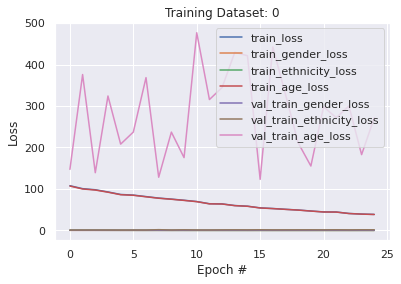

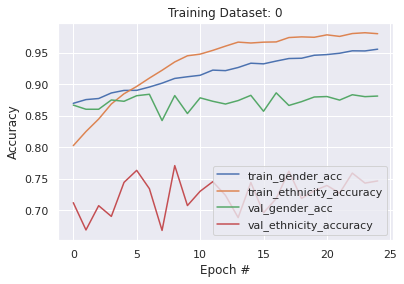

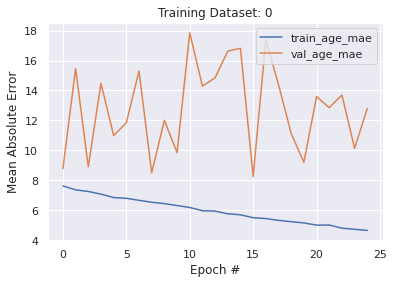

In [ ]:
#PLOTS
plot_loss(history_list[0], epochs, f'Training Dataset: {0}')
plot_acc(history_list[0], epochs, f'Training Dataset: {0}')
plot_MSE(history_list[0], epochs, f'Training Dataset: {0}')

# **Visualizing architecture of the model**

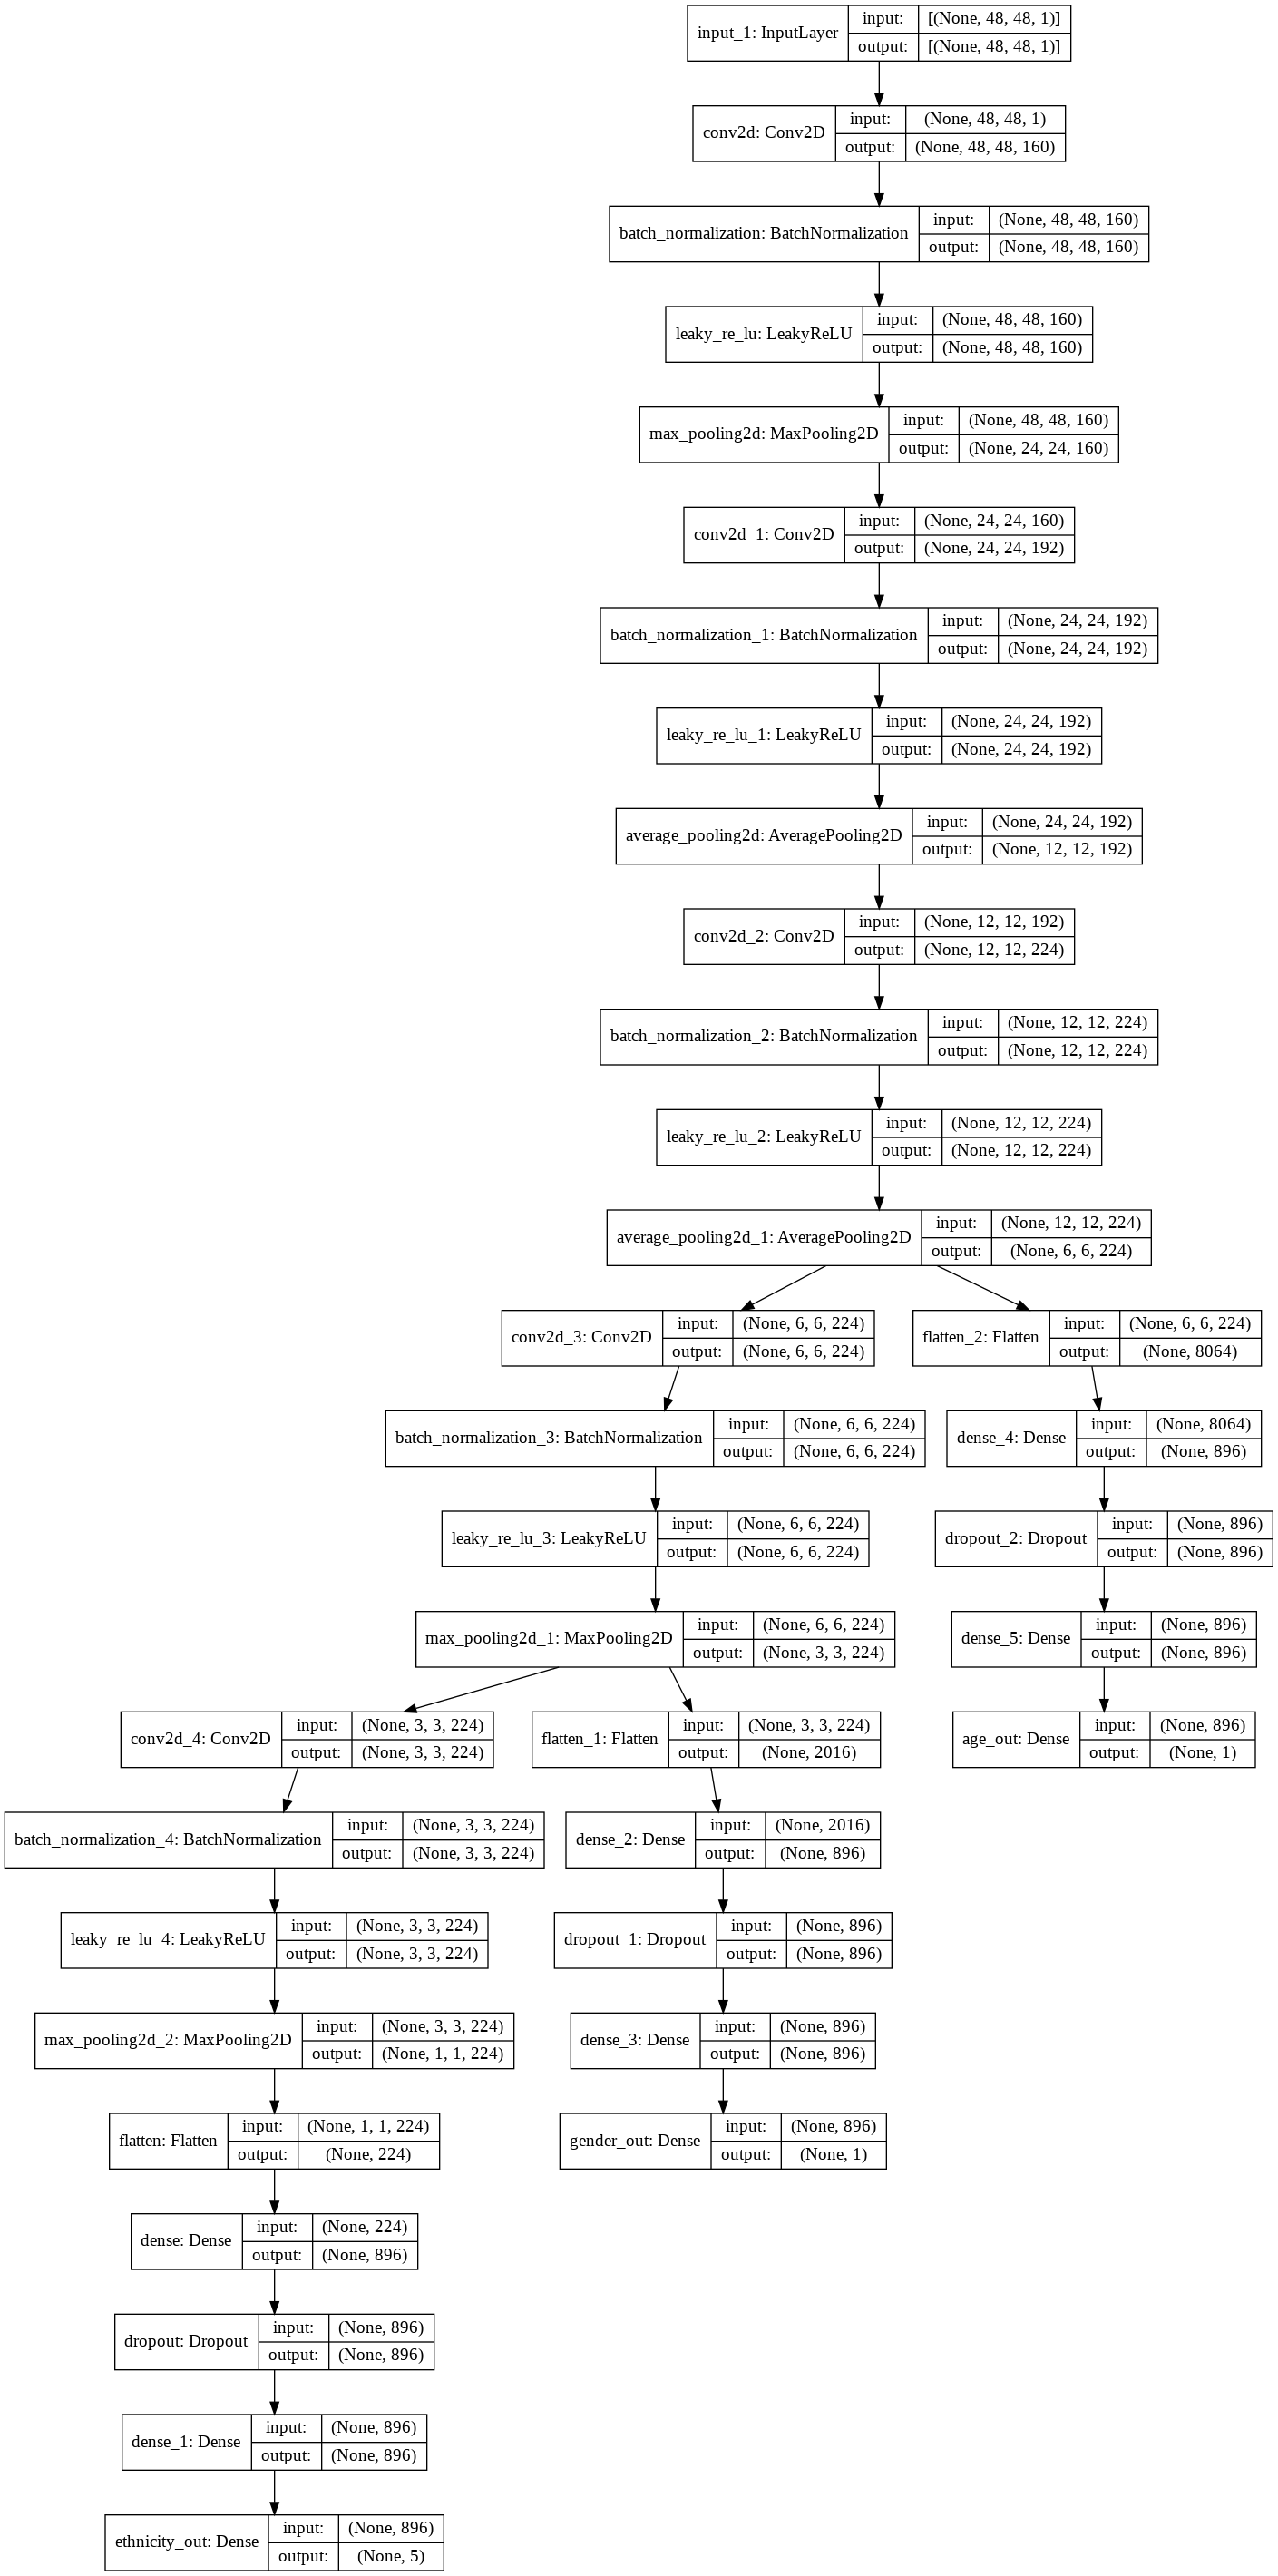

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96
)

# **Making predictions on test data**

In [ ]:
#predicting
pred = model.predict(X_test)

#Printing
#Accuracy in gender prediction
#Accuracy in ethnicity prediction
#Age mae in age prediction
test_loss,test_gender_loss, test_ethnicity_loss, test_age_loss, test_gender_acc,test_ethnicity_acc,test_age_mae = model.evaluate(X_test, [y_gender_test, y_ethnicity_test, y_age_test], verbose=0)
print(f'\nTest gender accuracy: {test_gender_acc}')
print(f'\nTest ethnicity accuracy: {test_ethnicity_acc}')
print(f'\nTest age MAE: {test_age_mae}')


Test gender accuracy: 0.8801131248474121

Test ethnicity accuracy: 0.7425070405006409

Test age MAE: 12.607101440429688


Confusion Matrix
Classification Report
              precision    recall  f1-score   support

        Male       0.88      0.90      0.89      2817
      Female       0.88      0.86      0.87      2488

    accuracy                           0.88      5305
   macro avg       0.88      0.88      0.88      5305
weighted avg       0.88      0.88      0.88      5305



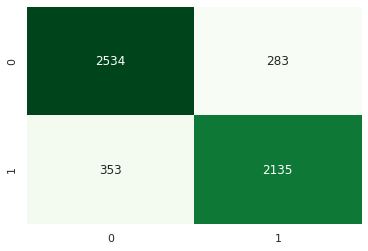

In [ ]:
# Confusion matrix for Age prediction
pr=np.round(pred[0])
# print(pr)
# print(y_gender_test)
np.round(pred[0], 2)
Y_pred_gender = pred[0]
Y_true_gender = y_gender_test
cm = confusion_matrix(Y_true_gender,pr)
print("Confusion Matrix")
#np.fill_diagonal(cm, 0) #Fill diagonal with 0 for better visualisation
sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Greens');
print('Classification Report')
target_names = ['Male', 'Female']
print(classification_report(Y_true_gender, pr, target_names=target_names))

In [ ]:
#Classification report for ethnicity
from sklearn.metrics import classification_report, confusion_matrix
Y_pred_Ethn = np.argmax(pred[1],axis=1)
Y_true_ethnicity = np.argmax(y_ethnicity_test,axis = 1)
print('Confusion Matrix')
print(confusion_matrix(Y_true_ethnicity, Y_pred_Ethn))
print('Classification Report')
target_names = ['white', 'black','asian','indian','others']
print(classification_report(Y_true_ethnicity, Y_pred_Ethn, target_names=target_names))

Confusion Matrix
[[1926   93   12  147   49]
 [ 109  792    8   59   10]
 [ 182   52  499   49   32]
 [ 155   67    7  665   20]
 [ 194   43   11   67   57]]
Classification Report
              precision    recall  f1-score   support

       white       0.75      0.86      0.80      2227
       black       0.76      0.81      0.78       978
       asian       0.93      0.61      0.74       814
      indian       0.67      0.73      0.70       914
      others       0.34      0.15      0.21       372

    accuracy                           0.74      5305
   macro avg       0.69      0.63      0.65      5305
weighted avg       0.74      0.74      0.73      5305



Confusion Matrix


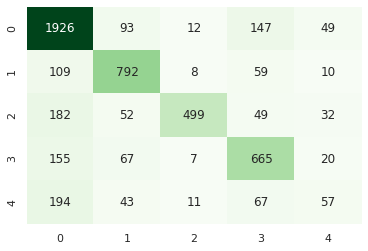

In [ ]:
#confusion matrix for ethnicity
cm = confusion_matrix(Y_true_ethnicity,Y_pred_Ethn)
print("Confusion Matrix")
#np.fill_diagonal(cm, 0) #Fill diagonal with 0 for better visualisation
sns.heatmap(cm, annot=True, fmt='d', cbar=False, cmap='Greens');

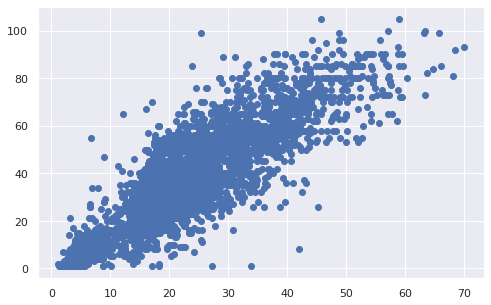

In [ ]:
#Plotting predicted age versus the actual labels of test, Ideally it should have been a staright line
plt.figure(figsize=(8, 5))
plt.scatter(pred[2], y_age_test);